## DASK を活用した探索的データ解析（EDA）

#### csvデータの読込み

In [1]:
%load_ext lab_black

In [2]:
import dask.dataframe as dd

df = dd.read_csv("../data/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


- `npartitions`はcsvデータを何個のブロックに分けて処理を行ったかを確認できます。
- `blocksize`を指定する事で分割処理も可能です（単位：byte）

In [3]:
print(df.npartitions)

1


In [4]:
df_2 = dd.read_csv("../data/Iris.csv", blocksize=3000)
print(df_2.npartitions)

2


#### 和・平均

In [5]:
df_sum = df.sum()
print("sum¥n", df_sum)

sum¥n Dask Series Structure:
npartitions=1
Id         object
Species       ...
dtype: object
Dask Name: dataframe-sum-agg, 3 tasks


In [6]:
df_mean = df.mean()
print("mean¥n", df_mean)

mean¥n Dask Series Structure:
npartitions=1
Id         float64
Species        ...
dtype: float64
Dask Name: dataframe-mean, 7 tasks


#### delayed() と compute()

- `delayed()`は関数を引数にとることで関数の実行そのものを任意の段階に遅らせることができます。
- つまり、計算の定義だけを先に組み上げて最後に一気に計算できます

In [7]:
from dask import delayed


def inc(x):
    return x + 1


print("Not delayed: ", inc(10))

x = delayed(inc, pure=True)(10)
print("delayed: ", x)

print("delayed compute: ", x.compute())

Not delayed:  11
delayed:  Delayed('inc-1e2248bfe27591bc987b2d27246533f3')
delayed compute:  11


`compute()`前の`delayed`の出力にはハッシュ値が添えられていますがこれは同じ関数を複数回呼びだされた時に区別するためのもの

In [8]:
df_sum = df.sum()
print(df_sum.compute())

df_mean = df.mean()
print(df_mean.compute())

Id                                                           11325
SepalLengthCm                                                876.5
SepalWidthCm                                                 458.1
PetalLengthCm                                                563.8
PetalWidthCm                                                 179.8
Species          Iris-setosaIris-setosaIris-setosaIris-setosaIr...
dtype: object
Id               75.500000
SepalLengthCm     5.843333
SepalWidthCm      3.054000
PetalLengthCm     3.758667
PetalWidthCm      1.198667
dtype: float64


##  EDAの実行

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd

df = dd.read_csv("../data/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 欠損値の確認

In [10]:
df.isnull().sum().compute()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 記述統計量の把握

In [11]:
df.describe().compute()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### データの可視化

<AxesSubplot:>

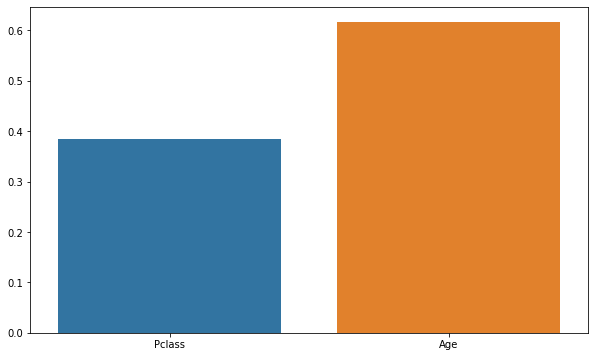

In [12]:
mean = df["Survived"].mean().compute()
prop_df = pd.DataFrame(
    data=[[mean, 1 - mean]],
    index=None,
    columns=["Pclass", "Age"],
)

## Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

sns.barplot(
    data=prop_df,
    order=["Pclass", "Age"],
    ax=ax,
)